# Statistical hypothesis testing

URL https://github.com/FIIT-IAU/

**We want to verify whether the number of engine cylinders has an effect on consumption.**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing

from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import numpy as np

from statsmodels.formula.api import ols


In [ ]:
cars = pd.read_csv('data/auto-mpg.data',
                   sep='\\s+',
                   names = ['mpg', 'cylinders', 'displacement','horsepower',
                            'weight', 'acceleration', 'model_year', 'origin', 'name'],
                   na_values='?')
cars.head()

## Homework

a. Check if the difference in fuel consumption between 4-cylinder and 6-cylinder engines is statistically significant.

b. Check if the difference in fuel consumption between 4-cylinder and 5-cylinder engines is statistically significant.

c. An even better approach is to use a statistical test that allows for the comparison of multiple groups at once. The generalization of the t-test for multiple groups is called **ANOVA (Analysis of Variance)**.

Invisible note
<!--
Care should be taken with repeated pair testing. With each additional test, the probability of the 1st order increases. In that case, a correction for retesting should be used, e.g. *Bonferroni correction*, when the $p$-value is compared against the $\alpha / m$ value, where $\alpha$ is the permissible value of the probability of the 1st order error and $m$ is the number of tested hypotheses (pairwise tests).
//-->

# EDA

In [ ]:
cars.dtypes

In [ ]:
cars.shape

In [ ]:
cars.info()

In [ ]:
cars.isnull().sum()

In [ ]:
# dropni riadky s NA
cars = cars.dropna(subset=['horsepower'])
cars.shape

In [ ]:
cars.isna().sum()

In [ ]:
sns.set(style="whitegrid", context="notebook")

numeric = cars.select_dtypes(include=['float64', 'int64']).columns
cars[numeric].describe()

#### Distribúcie číselných premenných

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric):
    sns.histplot(cars[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribúcia: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Počet áut')

# ak je počet grafov menší než počet subplotov, zvyšné vypneme
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Boxplot mpg podľa počtu valcov

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=cars['cylinders'], y='mpg', data=cars)
plt.xlabel('Počet valcov')
plt.ylabel('MPG (spotreba – míle na galón)')
plt.title('MPG podľa počtu valcov')
plt.show()

6-valcové: výrazne asymetrické a extrémne hodnoty (outliery) môžu ovplyvniť výsledky testov.

In [ ]:
six = cars[cars['cylinders'] == 6]
q1 = six['mpg'].quantile(0.25)
q3 = six['mpg'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

six_no_out = six[(six['mpg'] >= lower) & (six['mpg'] <= upper)]

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=cars_no_out['cylinders'], y='mpg', data=cars_no_out)
plt.xlabel('Počet valcov')
plt.ylabel('MPG (spotreba – míle na galón)')
plt.title('MPG podľa počtu valcov (bez outlierov)')
plt.show()

In [ ]:
cars_clean = pd.concat([
    cars[cars['cylinders'] != 6],
    six_no_out
])
cars_no_out = cars_clean.copy()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.boxplot(x=cars['cylinders'].astype(str), y='mpg', data=cars, ax=axes[0])
axes[0].set_title('Pôvodné dáta')

sns.boxplot(x=cars_clean['cylinders'].astype(str), y='mpg', data=cars_clean, ax=axes[1])
axes[1].set_title('Bez extrémov pri 6 valcoch')

plt.show()

In [ ]:
import statsmodels.api as sm

for c in sorted(cars['cylinders'].dropna().unique()):
    plt.figure(figsize=(4,4))
    sm.qqplot(cars.loc[cars['cylinders']==c, 'mpg'], line='s')
    plt.title(f'cylinders={c}')
    plt.show()

### Predpoklady pre hypotézy ANOVA
- H₀ (ANOVA): Priemerné mpg je rovnaké pre všetky skupiny valcov (4, 6, 8).
- H₁: Aspoň jedna skupina sa líši.

#### 1. Normalita v skupinách:


In [ ]:
for c in sorted(cars['cylinders'].dropna().unique()):
    x = cars.loc[cars['cylinders']==c, 'mpg'].dropna()
    if len(x) >= 3 and len(x) <= 5000:  # Shapiro limit
        stat, p = shapiro(x)
        print(f'cyl={c}: Shapiro p={p:.4f}, n={len(x)}')

##### Notes
- cyl=4 --> OK (p > 0.05)
- cyl=5 a cyl=3 --> má málo dát, ťažko posúdiť normalitu
- cyl=6 a cyl=8 --> p=0.0000 (p < 0.05), teda zamietame H₀ o normalite

Záver: ANOVA nie je vhodná ako primárny test

#### 2. Homogenita variancií (Levene):

In [ ]:
groups = [cars.loc[cars['cylinders']==c, 'mpg'].dropna() for c in sorted(cars['cylinders'].dropna().unique())]
stat, p = levene(*groups, center='median')  # median je robustnejší
print(f'Levene p={p:.4f}')

- potvrdenie ze ANOVA nie je vhodná ako primárny test (p < 0.05)

## Mann–Whitney U test (neparametrický)

### a. porovnanie 4 vs 6 valcov

In [ ]:
from scipy.stats import mannwhitneyu

# 4 vs 6
x4 = cars.loc[cars['cylinders']==4, 'mpg']
x6 = cars.loc[cars['cylinders']==6, 'mpg']
stat_46, p_46 = mannwhitneyu(x4, x6, alternative='two-sided')
print(f'4 vs 6 -> U={stat_46:.2f}, p={p_46:.6f}')

### b. porovnanie 4 vs 5 valcov

In [ ]:
x5 = cars.loc[cars['cylinders']==5, 'mpg']
stat_45, p_45 = mannwhitneyu(x4, x5, alternative='two-sided')
print(f'4 vs 5 -> U={stat_45:.2f}, p={p_45:.6f}')

##### Notes
- 4 vs 6: p < 0.05 → štatisticky významný rozdiel
- 4 vs 5: p > 0.05 → žiadny štatisticky významný rozdiel

Vysledok: Parametrický t-test nie je vhodný

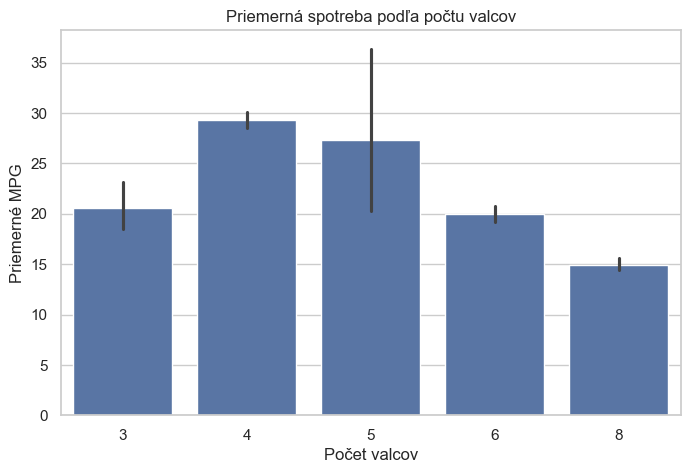

In [252]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=cars['cylinders'],
    y=cars['mpg'],
    estimator=np.mean
)
plt.xlabel('Počet valcov')
plt.ylabel('Priemerné MPG')
plt.title('Priemerná spotreba podľa počtu valcov')
plt.show()

## c. Testy ANOVA


In [ ]:
summary = cars.groupby('cylinders')['mpg'].agg(n='count', mean='mean', std='std', median='median')
summary


### Varianta A: Klasická ANOVA

In [ ]:
model = ols('mpg ~ C(cylinders)', data=cars).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

### Varianta B: Welch ANOVA

In [ ]:
model = ols('mpg ~ C(cylinders)', data=cars).fit()

# Welch ANOVA = ANOVA s robustnou korekciou (HC3)
welch_anova = sm.stats.anova_lm(model, typ=2, robust="hc3")
welch_anova

## Report
Na základe analýzy dát môžeme konštatovať, že počet valcov v automobile má štatisticky významný vplyv na spotrebu paliva (`mpg`). Predpoklady klasickej ANOVA (normalita a homogenita variancií) neboli splnené, preto bola použitá robustnejšia metóda Welch ANOVA, ktorá potvrdila signifikantný rozdiel medzi skupinami (p < 0.001). 

Post-hoc porovnania ukázali, že najväčší rozdiel sa prejavuje medzi 4-valcovými a 6-valcovými motormi – 4-valcové vozidlá majú podstatne vyššie hodnoty mpg, teda nižšiu spotrebu. Rozdiel medzi 4-valcovými a 5-valcovými motormi je taktiež štatisticky významný, avšak je potrebné brať do úvahy veľmi malý počet vozidiel s 5 valcami v datasete.


### Zhrnutie výsledkov testov:
- Mann–Whitney U test:
    - 4 vs 6 valcov: p < 0.05 → štatisticky významný rozdiel
    - 4 vs 5 valcov: p > 0.05 → žiadny štatisticky významný rozdiel
- Welch ANOVA: p < 0.001 → počet valcov má významný vplyv na spotrebu paliva (mpg).
- Post-hoc analýza: Najväčší rozdiel medzi 4-valcovými a 6-valcovými motormi.

